### Dependencies

In [2]:
import numpy as np
import torch
import torch.nn as nn
from utils import *

### View data distribution per set

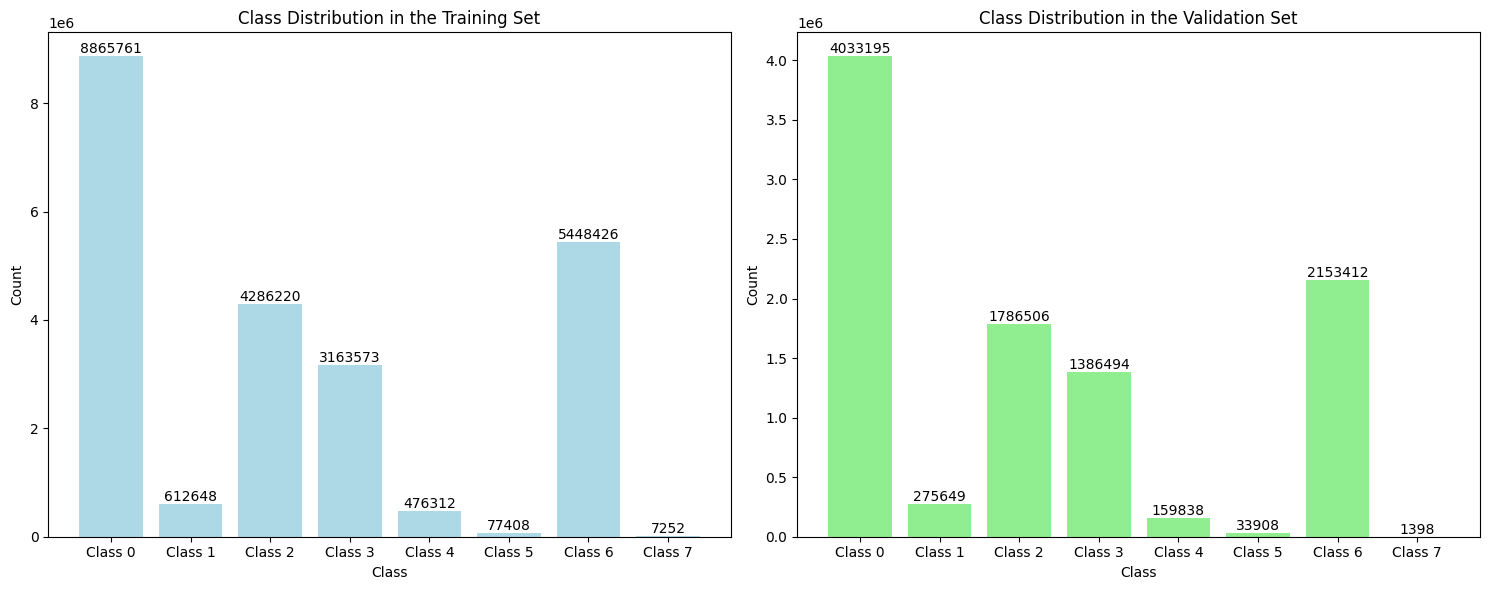

In [57]:
dataset, train_loader, val_loader = get_dataloaders(path="generated_dataset.npz", batch_size=16, train_split=0.7, seed=42)
num_classes = len(np.unique(dataset.y))
plot_class_distribution(train_loader, val_loader, num_classes)

### Grid Search Initial Learning Rate

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rates = [0.01, 0.001, 0.0001, 0.00001]
num_epochs = 100
best_scores = {}
all_metrics = {}
for lr in learning_rates:
    model = UNetResNet50(input_channels=13, num_classes=num_classes)
    print(f"\nRunning experiment with initial learning rate = {lr}")
    all_metrics[lr], best_scores[lr] = train_model(model, num_epochs, device, train_loader, val_loader, num_classes, lr)

sorted_scores = sorted(best_scores.items(), key=lambda x: x[1], reverse=True)
print("\n===== Model Ranked by Best Composite Score (0.5 * Pixel Accuracy + 0.5 * Macro-Averaged IoU) =====")
for rank, (lr, score) in enumerate(sorted_scores, start=1):
    print(f"{rank}. Learning Rate: {lr:<10} | Best Score: {score:.4f}")



Running experiment with initial learning rate = 0.01

Epoch 1
	Average Training Loss:  0.9106
	Average Validation Loss:  0.6873
	Pixel-Level Accuracy:  0.7159
	Macro-Averaged IoU:  0.2642
	Saved new best model.

Epoch 2
	Average Training Loss:  0.7607
	Average Validation Loss:  0.6381
	Pixel-Level Accuracy:  0.7956
	Macro-Averaged IoU:  0.3356
	Saved new best model.

Epoch 3
	Average Training Loss:  0.7262
	Average Validation Loss:  0.6725
	Pixel-Level Accuracy:  0.7570
	Macro-Averaged IoU:  0.2912

Epoch 4
	Average Training Loss:  0.7064
	Average Validation Loss:  0.8215
	Pixel-Level Accuracy:  0.6502
	Macro-Averaged IoU:  0.2548

Epoch 5
	Average Training Loss:  0.7194
	Average Validation Loss:  0.8191
	Pixel-Level Accuracy:  0.7259
	Macro-Averaged IoU:  0.2843

Epoch 6
	Average Training Loss:  0.7082
	Average Validation Loss:  0.5851
	Pixel-Level Accuracy:  0.7663
	Macro-Averaged IoU:  0.3176

Epoch 7
	Average Training Loss:  0.7221
	Average Validation Loss:  0.7453
	Pixel-Level Ac

### Evaluate best models

In [49]:
criterion = nn.CrossEntropyLoss()
best_model_val_metrics = {}
for lr in learning_rates:
    print(f"Evaluating best model for initial learning rate {lr} on the validation set")
    model = UNetResNet50(input_channels=13, num_classes=num_classes)
    model.load_state_dict(torch.load(f"best_model_lr_{lr}.pt", map_location=torch.device("cpu"), weights_only=True))
    best_model_val_metrics[lr] = validate(model, val_loader, device, criterion, num_classes)

sorted_metrics = sorted(best_model_val_metrics.items(), key=lambda x: x[1]["Macro-Averaged IoU"], reverse=True)
print(f'\n{"Learning Rate":<15}{"Macro-Averaged IoU":<25}{"Pixel-Level Accuracy"}')
print("-" * 60)
for lr, metric in sorted_metrics:
    print(f'{lr:<15}{metric["Macro-Averaged IoU"]:<25.4f}{metric["Pixel-Level Accuracy"]:.4f}')

Evaluating best model for initial learning rate 0.01 on the validation set


/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating best model for initial learning rate 0.001 on the validation set
Evaluating best model for initial learning rate 0.0001 on the validation set
Evaluating best model for initial learning rate 1e-05 on the validation set

Learning Rate  Macro-Averaged IoU       Pixel-Level Accuracy
------------------------------------------------------------
0.0001         0.6638                   0.8887
0.001          0.6479                   0.8856
0.01           0.4965                   0.8501
1e-05          0.4202                   0.8261


### Plot Training and Validation Metrics Throughout Training

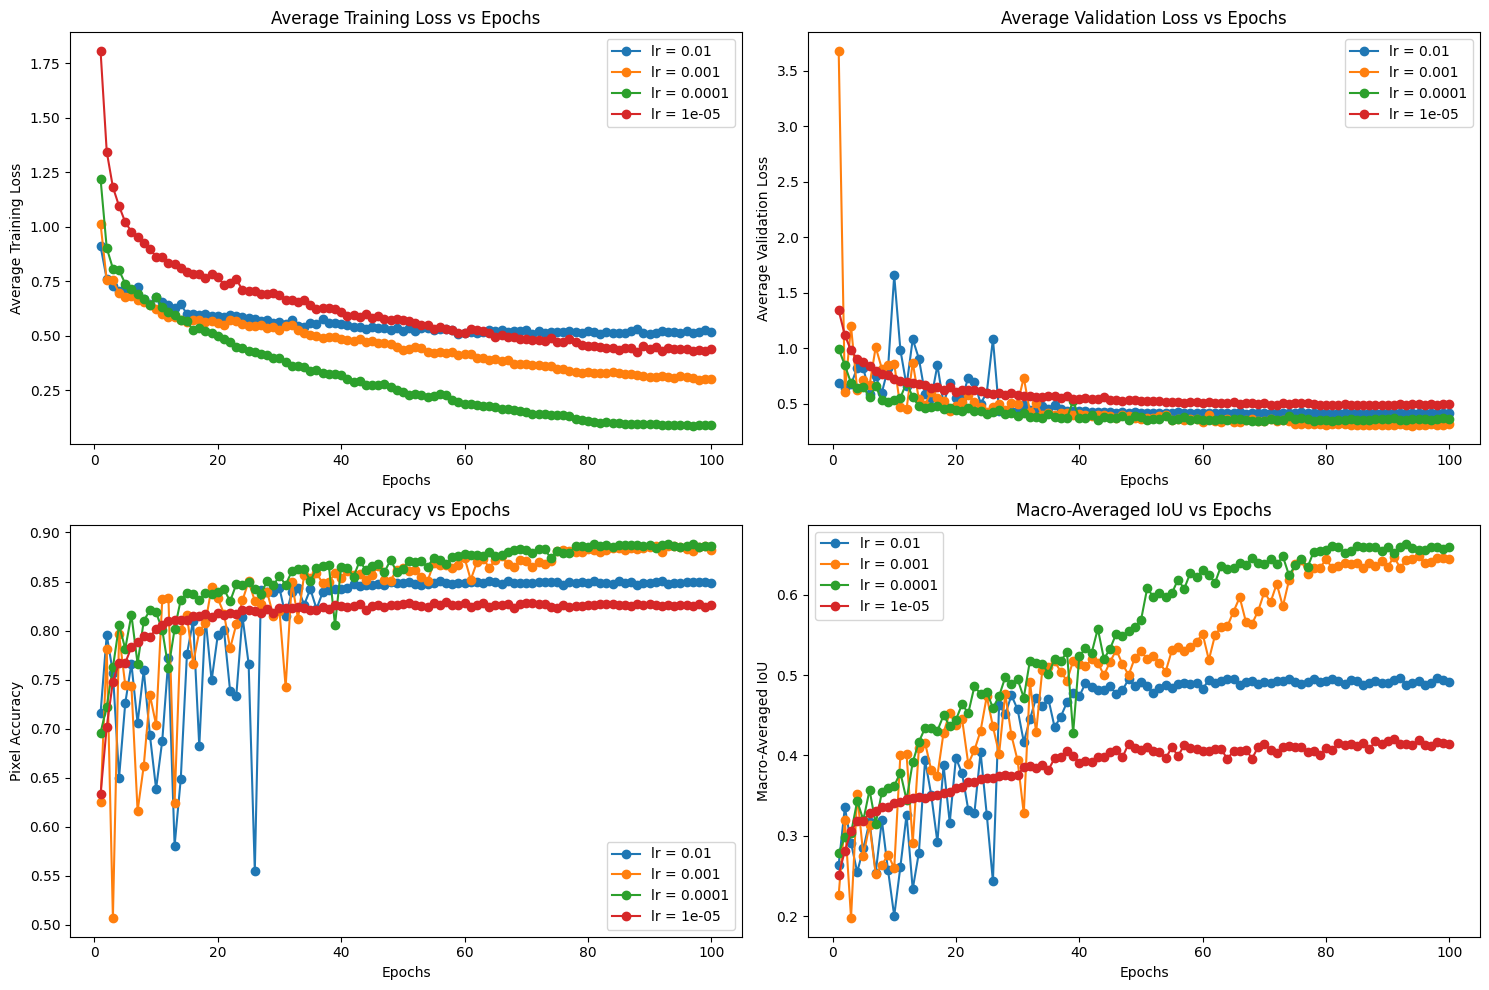

In [53]:
plot_metrics(all_metrics, num_epochs, learning_rates)

### Plot the Per-Class-IoU for each best model

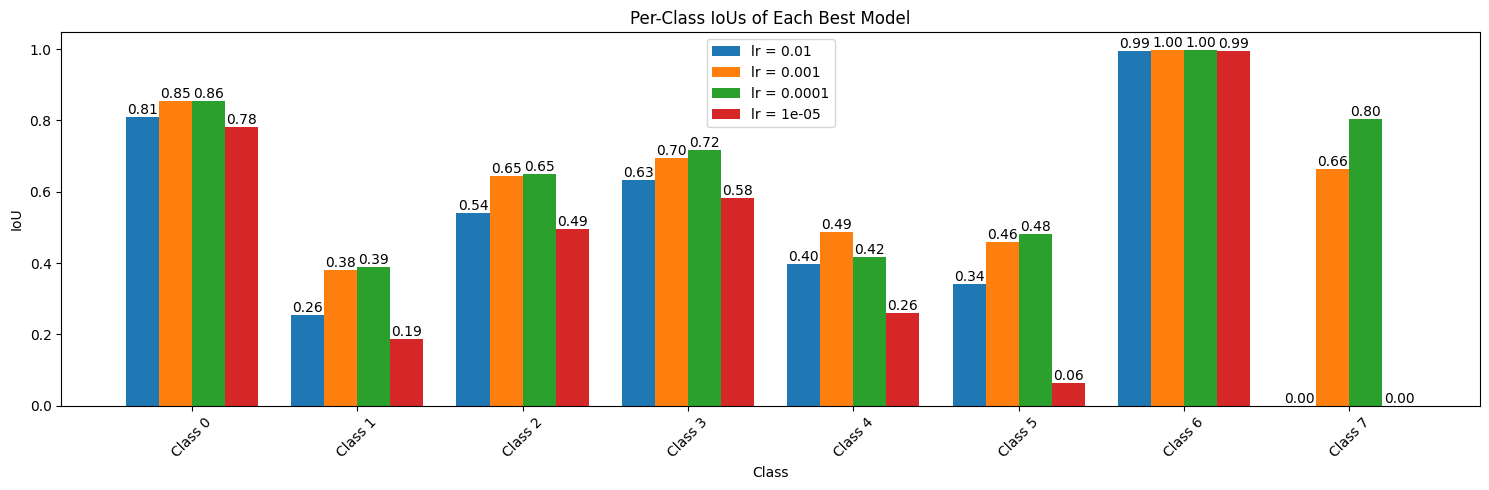

In [54]:
plot_per_class_ious(best_model_val_metrics, learning_rates, num_classes)